## Data Preparation

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.model_selection import train_test_split
from geopy.distance import vincenty, geodesic

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jan  4 14:25:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

This data preparation process is the dense and concise version described in `DataPreparation.ipynb`.

why user, trip, segement ?


is it good for time independent


is it good for the train, test, validation split


better for both CNN and RNN

`create_datesets` split the data into (user, trip, segements). Each trip contains all the segements

In [ ]:
def create_datasets_CNN():
    user = []
    label = []
    for path,directory,file in os.walk('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/'):
        for ind, filename in enumerate(file):
            # sort by timestamp
            user_data = np.load('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/' + filename) # shape (row, col)
            user_data_sorted = user_data[user_data[:,4].argsort()]
            #assert user_data_sorted[:,4].is_monotonic_increasing == True

            # split into trips
            trips = [] # (trip, segements, 4)
            i = 0
            for j in range(1,len(user_data_sorted)):
                if user_data_sorted[j,4] - user_data_sorted[j-1,4] <= 1200:
                    continue
                # print(np.array(user_data_sorted[i:j]))
                trips.append(user_data_sorted[i:j])
                i = j
            # print(len(trips))
            
            # split into segements for each trip
            for ind,trip in enumerate(trips):  # user -> trips -> segements
                temp_segements = []
                i = 0
                for j in range(1, len(trip)):
                    if trip[j,5] == trip[j-1,5]:
                        continue
                    temp_segements.append(trip[i:j])
                    i = j
                if(temp_segements):
                    trips[ind] = temp_segements
                else:
                    trips[ind] = [trip]
                # print("size: ",len(trips[ind]))
                # assert np.array(temp_segements).ndim == 2

            # calculate channel data
            trips_2 = []
            targets = []#np.empty((1))
            for ind,trip in enumerate(trips):
                temp_segement = []
                temp_target = []
                for ind2, segement in enumerate(trip): # segement with same mode under same trip
                    segement_4d = []

                    # drop mode 100
                    if(segement[0,5] == 100):
                        continue

                    for i in range(len(segement)-2):
                        p1 = (np.radians(segement[i,1]), np.radians(segement[i,2]))
                        p2 = (np.radians(segement[i+1,1]), np.radians(segement[i+1,2]))
                        p3 = (np.radians(segement[i+2,1]), np.radians(segement[i+2,2]))
                        dist = geodesic(p1, p2).meters
                        #print(dist)
                        t = segement[i+1,4] - segement[i,4]
                        if t == 0:
                            continue
                        speed = dist / t
                        acceleration = speed / t
                        jerk = acceleration / t

                        # Bearing Rate
                        y_1 = np.sin(p2[1] - p1[1]) * np.cos(p2[0])
                        x_1 = np.cos(p1[0])*np.sin(p2[0]) - np.sin(p1[0])*np.cos(p2[0])*np.cos(p2[1] - p1[1])
                        bearing_p1 = np.degrees(np.arctan2(y_1, x_1))

                        y_2 = np.sin(p3[1] - p2[1]) * np.cos(p3[0])
                        x_2 = np.cos(p2[0])*np.sin(p3[0]) - np.sin(p2[0])*np.cos(p3[0])*np.cos(p3[1] - p2[1])
                        bearing_p2 = np.degrees(np.arctan2(y_2, x_2))

                        bearing_rate = np.abs(bearing_p2 - bearing_p1)

                        mode = segement[i,5]
                        
                        # bus
                        if mode == 0 and (speed > 34 or acceleration > 2): 
                            continue
                        # train
                        if mode == 1 and (speed > 34 or acceleration > 3): 
                            continue
                        # walk
                        if mode == 2 and (speed > 7 or acceleration > 3): 
                            continue
                        # car
                        if mode == 3 and (speed > 50 or acceleration > 10): 
                            continue
                        # bike
                        if mode == 4 and (speed > 12 or acceleration > 3): 
                            continue
                        segement_4d.append([speed, acceleration, jerk, bearing_rate])
                        
                        if len(segement_4d) % 200 == 0:                              
                            # print(np.array(segement_4d).shape)
                            temp_segement.append(segement_4d)
                            temp_target.append(segement[0,5])
                            segement_4d = []
                            # print(np.array(segement_4d).shape)
                if len(temp_segement) > 0:
                    # print( np.array(temp_segement).shape)
                    trips_2.append(temp_segement)
                    targets.append(temp_target)
            if len(trips_2) > 0:
                user.append(trips_2)
                label.append(targets)
                # print("size(segements_4d)", np.array(trips_2).shape)
                # print("size(target)", np.array(targets).shape)
    return user, label
        


`create_datesets_RNN` split the trip every seq_size segements



In [ ]:

def create_datasets_RNN(seq_size):
    user = []
    label = []
    for path,directory,file in os.walk('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/'):
        for ind, filename in enumerate(file):
            # sort by timestamp
            user_data = np.load('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/' + filename) # shape (row, col)
            user_data_sorted = user_data[user_data[:,4].argsort()]
            #assert user_data_sorted[:,4].is_monotonic_increasing == True

            # split into trips
            trips = [] # (trip, segements, 4)
            i = 0
            for j in range(1,len(user_data_sorted)):
                if user_data_sorted[j,4] - user_data_sorted[j-1,4] <= 1200:
                    continue
                # print(np.array(user_data_sorted[i:j]))
                trips.append(user_data_sorted[i:j])
                i = j
            # print(len(trips))
            
            # split into segements for each trip
            for ind,trip in enumerate(trips):  # user -> trips -> segements
                temp_segements = []
                i = 0
                for j in range(1, len(trip)):
                    if trip[j,5] == trip[j-1,5]:
                        continue
                    temp_segements.append(trip[i:j])
                    i = j
                if(temp_segements):
                    trips[ind] = temp_segements
                else:
                    trips[ind] = [trip]
                # print("size: ",len(trips[ind]))
                # assert np.array(temp_segements).ndim == 2

            # calculate channel data
            trips_2 = []
            targets = []#np.empty((1))
            for ind,trip in enumerate(trips):
                temp_segement = []
                temp_target = []
                for ind2, segement in enumerate(trip): # segement with same mode under same trip
                    segement_4d = []

                    # drop mode 100
                    if(segement[0,5] == 100):
                        continue

                    for i in range(len(segement)-2):
                        p1 = (np.radians(segement[i,1]), np.radians(segement[i,2]))
                        p2 = (np.radians(segement[i+1,1]), np.radians(segement[i+1,2]))
                        p3 = (np.radians(segement[i+2,1]), np.radians(segement[i+2,2]))
                        dist = geodesic(p1, p2).meters
                        #print(dist)
                        t = segement[i+1,4] - segement[i,4]
                        if t == 0:
                            continue
                        speed = dist / t
                        acceleration = speed / t
                        jerk = acceleration / t

                        # Bearing Rate
                        y_1 = np.sin(p2[1] - p1[1]) * np.cos(p2[0])
                        x_1 = np.cos(p1[0])*np.sin(p2[0]) - np.sin(p1[0])*np.cos(p2[0])*np.cos(p2[1] - p1[1])
                        bearing_p1 = np.degrees(np.arctan2(y_1, x_1))

                        y_2 = np.sin(p3[1] - p2[1]) * np.cos(p3[0])
                        x_2 = np.cos(p2[0])*np.sin(p3[0]) - np.sin(p2[0])*np.cos(p3[0])*np.cos(p3[1] - p2[1])
                        bearing_p2 = np.degrees(np.arctan2(y_2, x_2))

                        bearing_rate = np.abs(bearing_p2 - bearing_p1)

                        mode = segement[i,5]
                        
                        # bus
                        if mode == 0 and (speed > 34 or acceleration > 2): 
                            continue
                        # train
                        if mode == 1 and (speed > 34 or acceleration > 3): 
                            continue
                        # walk
                        if mode == 2 and (speed > 7 or acceleration > 3): 
                            continue
                        # car
                        if mode == 3 and (speed > 50 or acceleration > 10): 
                            continue
                        # bike
                        if mode == 4 and (speed > 12 or acceleration > 3): 
                            continue
                        segement_4d.append([speed, acceleration, jerk, bearing_rate])
                        
                        if len(segement_4d) % 200 == 0:                               # from 200 -> 50
                            # print(np.array(segement_4d).shape)
                            temp_segement.append(segement_4d)
                            temp_target.append(segement[0,5])
                            segement_4d = []
                            # print(np.array(segement_4d).shape)
                        if len(temp_segement) >= seq_size:
                            # print( np.array(temp_segement).shape)
                            trips_2.append(temp_segement)
                            targets.append(temp_target)
                            temp_segement = []
                            temp_target = []
            #if len(trips_2) > 0:
                user.append(trips_2)
                label.append(targets)
                # print("size(trips)", np.array(trips_2).shape)
                # print("size(target)", np.array(targets).shape)
            else:
                print("-1")
    return user, label
        


In [ ]:
userCNN, labelCNN = create_datasets_CNN()

In [ ]:
userRNN4, labelRNN4 = create_datasets_RNN(seq_size = 4)

In [ ]:
userRNN6, labelRNN6 = create_datasets_RNN(seq_size = 6)

In [ ]:
userRNN8, labelRNN8 = create_datasets_RNN(seq_size = 8)

In [ ]:
userRNN10, labelRNN10 = create_datasets_RNN(seq_size = 10)

In [ ]:
userRNN12, labelRNN12 = create_datasets_RNN(seq_size = 12)

In [ ]:
# # dump CNN dataset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userCNN.pickle', 'wb')
pickle.dump(userCNN, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelCNN.pickle", "wb")
pickle.dump(labelCNN, l)



In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN4.pickle', 'wb')
pickle.dump(userRNN4, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN4.pickle", "wb")
pickle.dump(labelRNN4, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN6.pickle', 'wb')
pickle.dump(userRNN6, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN6.pickle", "wb")
pickle.dump(labelRNN6, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN8.pickle', 'wb')
pickle.dump(userRNN8, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN8.pickle", "wb")
pickle.dump(labelRNN8, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN10.pickle', 'wb')
pickle.dump(userRNN10, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN10.pickle", "wb")
pickle.dump(labelRNN10, l)

In [ ]:
# dump RNN dateset
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN12.pickle', 'wb')
pickle.dump(userRNN12, u)
l = open("/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN12.pickle", "wb")
pickle.dump(labelRNN12, l)

In [2]:
# Restore CNN
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userCNN.pickle', 'rb')
userCNN = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelCNN.pickle', 'rb')
labelCNN = pickle.load(l)

# Restore RNN4
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN4.pickle', 'rb')
userRNN4 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN4.pickle', 'rb')
labelRNN4 = pickle.load(l)

# Restore RNN6
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN6.pickle', 'rb')
userRNN6 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN6.pickle', 'rb')
labelRNN6 = pickle.load(l)

# Restore RNN8
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN8.pickle', 'rb')
userRNN8 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN8.pickle', 'rb')
labelRNN8 = pickle.load(l)

# Restore RNN10
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN10.pickle', 'rb')
userRNN10 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN10.pickle', 'rb')
labelRNN10 = pickle.load(l)

# Restore RNN12
u = open('/content/drive/My Drive/Colab Notebooks/DPproject/userRNN12.pickle', 'rb')
userRNN12 = pickle.load(u)
l = open('/content/drive/My Drive/Colab Notebooks/DPproject/labelRNN12.pickle', 'rb')
labelRNN12 = pickle.load(l)

In [ ]:
print('user')

print(len(userRNN4))
print(len(userRNN6))
print(len(userRNN8))
print(len(userRNN10))
print(len(userRNN12))

print('label')
print(len(labelRNN4))
print(len(labelRNN6))
print(len(labelRNN8))
print(len(labelRNN10))
print(len(labelRNN12))

user
33
29
28
28
24
label
33
29
28
28
24


0. BUS
1. Train & Subway
2. Walk & Run
3. Car & Taxi & Motocycle
4. Bike?
100. others


In [ ]:
# for i in user:
#     for j in i:
#         print(np.array(j).shape)
for i in userRNN10:
    print(np.array(i).shape)
# print(np.array(user[5]).shape)
# print(len(user[1][0]))

(11, 10, 200, 4)
(9, 10, 200, 4)
(26, 10, 200, 4)
(1, 10, 200, 4)
(162, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(25, 10, 200, 4)
(58, 10, 200, 4)
(56, 10, 200, 4)
(27, 10, 200, 4)
(26, 10, 200, 4)
(7, 10, 200, 4)
(8, 10, 200, 4)
(3, 10, 200, 4)
(9, 10, 200, 4)
(21, 10, 200, 4)
(4, 10, 200, 4)
(7, 10, 200, 4)
(35, 10, 200, 4)
(1, 10, 200, 4)
(1, 10, 200, 4)
(2, 10, 200, 4)
(10, 10, 200, 4)
(5, 10, 200, 4)
(1, 10, 200, 4)


In [ ]:
for i in userRNN4:
    print(np.array(i).shape)

(62, 4, 200, 4)
(4, 4, 200, 4)
(1, 4, 200, 4)
(42, 4, 200, 4)
(86, 4, 200, 4)
(2, 4, 200, 4)
(10, 4, 200, 4)
(463, 4, 200, 4)
(1, 4, 200, 4)
(2, 4, 200, 4)
(2, 4, 200, 4)
(29, 4, 200, 4)
(7, 4, 200, 4)
(1, 4, 200, 4)
(185, 4, 200, 4)
(256, 4, 200, 4)
(353, 4, 200, 4)
(125, 4, 200, 4)
(162, 4, 200, 4)
(34, 4, 200, 4)
(26, 4, 200, 4)
(17, 4, 200, 4)
(61, 4, 200, 4)
(118, 4, 200, 4)
(24, 4, 200, 4)
(81, 4, 200, 4)
(180, 4, 200, 4)
(11, 4, 200, 4)
(34, 4, 200, 4)
(14, 4, 200, 4)
(125, 4, 200, 4)
(31, 4, 200, 4)
(12, 4, 200, 4)


In [ ]:
for i in userRNN6:
    print(np.array(i).shape)

(29, 6, 200, 4)
(1, 6, 200, 4)
(22, 6, 200, 4)
(49, 6, 200, 4)
(4, 6, 200, 4)
(293, 6, 200, 4)
(1, 6, 200, 4)
(1, 6, 200, 4)
(16, 6, 200, 4)
(3, 6, 200, 4)
(101, 6, 200, 4)
(133, 6, 200, 4)
(166, 6, 200, 4)
(67, 6, 200, 4)
(77, 6, 200, 4)
(17, 6, 200, 4)
(13, 6, 200, 4)
(8, 6, 200, 4)
(24, 6, 200, 4)
(68, 6, 200, 4)
(13, 6, 200, 4)
(42, 6, 200, 4)
(96, 6, 200, 4)
(2, 6, 200, 4)
(14, 6, 200, 4)
(8, 6, 200, 4)
(48, 6, 200, 4)
(13, 6, 200, 4)
(3, 6, 200, 4)


In [ ]:
for i in userRNN8:
    print(np.array(i).shape)

(18, 8, 200, 4)
(15, 8, 200, 4)
(32, 8, 200, 4)
(1, 8, 200, 4)
(204, 8, 200, 4)
(1, 8, 200, 4)
(1, 8, 200, 4)
(1, 8, 200, 4)
(1, 8, 200, 4)
(41, 8, 200, 4)
(80, 8, 200, 4)
(102, 8, 200, 4)
(40, 8, 200, 4)
(46, 8, 200, 4)
(11, 8, 200, 4)
(9, 8, 200, 4)
(5, 8, 200, 4)
(16, 8, 200, 4)
(38, 8, 200, 4)
(6, 8, 200, 4)
(15, 8, 200, 4)
(59, 8, 200, 4)
(1, 8, 200, 4)
(10, 8, 200, 4)
(3, 8, 200, 4)
(24, 8, 200, 4)
(7, 8, 200, 4)
(1, 8, 200, 4)


In [ ]:
for i in userRNN12:
    print(np.array(i).shape)

(5, 12, 200, 4)
(5, 12, 200, 4)
(17, 12, 200, 4)
(1, 12, 200, 4)
(128, 12, 200, 4)
(1, 12, 200, 4)
(15, 12, 200, 4)
(40, 12, 200, 4)
(32, 12, 200, 4)
(21, 12, 200, 4)
(19, 12, 200, 4)
(7, 12, 200, 4)
(6, 12, 200, 4)
(1, 12, 200, 4)
(3, 12, 200, 4)
(13, 12, 200, 4)
(2, 12, 200, 4)
(3, 12, 200, 4)
(27, 12, 200, 4)
(1, 12, 200, 4)
(2, 12, 200, 4)
(6, 12, 200, 4)
(2, 12, 200, 4)
(1, 12, 200, 4)


In [ ]:
np.unique(labelCNN)

array([list([[0.0, 0.0]]),
       list([[0.0, 0.0], [0.0], [0.0], [2.0, 2.0], [0.0, 0.0, 0.0], [2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [0.0, 2.0, 2.0, 2.0], [0.0, 0.0, 0.0], [2.0], [2.0], [0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [2.0, 2.0, 2.0, 2.0, 2.0], [3.0], [0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [2.0, 0.0], [0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [2.0, 2.0], [3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 0.0, 0.0, 0.0], [2.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [2.0], [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [0.0, 0.0, 0.0], [2.0, 2.0, 2.0], [0.0, 0.0, 0.0, 0.0], [0.0], [2.0, 2.0, 2.0, 2.0, 2.

## Visualization

In [ ]:
# !pip install -q holoviews
# !pip install datashader

     |████████████████████████████████| 15.5MB 206kB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 1.6MB 48.3MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 
     |████████████████████████████████| 655kB 48.0MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp36-none-any.whl size=59430 sha256=a889a73cb8b54a4d73aa0425b06e549eefac797da1ab93344ca827a8ebe4f9c6
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=fece3c107ff1dace5b750eb577434b1ffa74b23473c46a092efde94574d1634c
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=33f885a77ef122db221a20eb0923952108b971512a622fb589d20

In [ ]:
import sys, os
data_sorted = np.empty((0, 6))
for path,directory,file in os.walk('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/'): 
    for ind, filename in enumerate(file):
        # sort by timestamp
        # sort by timestamp
        user_data = np.load('drive/My Drive/Colab Notebooks/DPproject/numpyL/user/' + filename) # shape (row, col)
        user_data_sorted = user_data[user_data[:,4].argsort()]
        data_sorted = np.vstack((data_sorted, user_data_sorted))
print(np.array(data_sorted).shape)
print(np.unique(data_sorted[:, 5]))
data = pd.DataFrame(data_sorted, columns = ['user_id', 'latitude','longitude', 'altitude','timestamp', 'mode']).astype({'user_id':'int64', 'latitude':'float64','longitude':'float64', 'altitude':'float64','timestamp':'int64', 'mode':'int64'} )
data

(5386677, 6)
[  0.   1.   2.   3.   4. 100.]


user_id   latitude   longitude    altitude   timestamp  mode
0             10  39.973450  116.327417  200.131234  1192022636     4
1             10  39.972817  116.327400  206.692913  1192022666     4
2             10  39.972400  116.327350  232.939633  1192022685     4
3             10  39.972200  116.327383  259.186352  1192022693     4
4             10  39.971950  116.327417  278.871391  1192022705     4
...          ...        ...         ...         ...         ...   ...
5386672        8  39.975308  116.330498  179.000000  1228954984     4
5386673        8  39.975303  116.330547  171.000000  1228954986     4
5386674        8  39.975300  116.330590  164.000000  1228954988     4
5386675        8  39.975286  116.330639  160.000000  1228954990     4
5386676        8  39.975283  116.330672  158.000000  1228954992     4

[5386677 rows x 6 columns]

In [ ]:
data.head(5)

user_id   latitude   longitude    altitude   timestamp  mode
0       10  39.973450  116.327417  200.131234  1192022636     4
1       10  39.972817  116.327400  206.692913  1192022666     4
2       10  39.972400  116.327350  232.939633  1192022685     4
3       10  39.972200  116.327383  259.186352  1192022693     4
4       10  39.971950  116.327417  278.871391  1192022705     4

In [ ]:
data.describe().apply("{0:.3f}".format)

user_id      latitude  ...     timestamp          mode
count  5.386677e+06  5.386677e+06  ...  5.386677e+06  5.386677e+06
mean   3.626056e+01  3.946732e+01  ...  1.239388e+09  2.094284e+00
std    1.927445e+01  2.383322e+00  ...  3.616806e+07  4.962046e+00
min    1.000000e+00  1.824990e+01  ...  1.176366e+09  0.000000e+00
25%    2.100000e+01  3.992277e+01  ...  1.216523e+09  1.000000e+00
50%    3.300000e+01  3.997505e+01  ...  1.223889e+09  2.000000e+00
75%    5.500000e+01  3.999115e+01  ...  1.245129e+09  3.000000e+00
max    6.900000e+01  4.001667e+02  ...  1.325341e+09  1.000000e+02

[8 rows x 6 columns]

In [ ]:
# show Beijing Map
x_range=[39.8, 40.1]
y_range=[116.25, 116.5]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
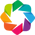

In [ ]:
import numpy as np
import holoviews as hv
from holoviews import opts
from holoviews.element.tiles import StamenTerrain
from datashader.utils import lnglat_to_meters
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Greys9

os.environ['HV_DOC_HTML'] = 'true'

hv.extension('bokeh')

In [ ]:
data_range = data[(data['latitude'] <= 40.1) & (data['latitude'] >=39.8)]
data_range = data_range[(data_range['longitude'] <= 116.5) & (data_range['longitude'] >=116.25)]
data_range.loc[:,'y'], data_range.loc[:,'x'] = lnglat_to_meters(data_range.longitude, data_range.latitude)

0. BUS
1. Train & Subway
2. Walk & Run
3. Car & Taxi & Motocycle
4. Bike?
100. others


In [ ]:
colors = ["green","red","yellow","cyan","white","blue"]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
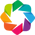

Invoked as dynamic_operation(height=400, scale=1.0, width=400, x_range=None, y_range=None)


ValueError: ignored

TypeError: ignored

In [ ]:
import holoviews as hv
from holoviews.element import tiles
from holoviews.operation.datashader import datashade, dynspread
import holoviews.operation.datashader as hd
from colorcet import fire
hv.extension('bokeh')

url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'
tile_opts  = dict(width=1000,height=600,xaxis=None,yaxis=None,bgcolor='black',show_grid=False)
map_tiles  = tiles.EsriImagery().opts(style=dict(alpha=0.5), plot=tile_opts)
points     = hv.Points(data_range, ['y', 'x'])
# taxi_trips = datashade(points, x_sampling=1, y_sampling=1, cmap=fire, width=1000, height=600)
shade =  datashade(points,aggregator=ds.count_cat('mode'), color_key=colors)
dyn = dynspread(shade, threshold=0.3, max_px=4).opts(bgcolor='black', xaxis=None, yaxis=None, width=1000, height=600)
map_tiles *dyn

## ## Define a Recurrent Neural Network seq_6


In [ ]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

Build the network based on the <span class="mark">yellow colored parameters</span>

![image.png](attachment:image.png)

In [ ]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


Running GPU.


### define train, validation, test set

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# split to train, valid, test set

x_remain_ind, x_test_ind, y_remain_ind, y_test_ind = train_test_split(list(range(len(userRNN6))),list(range(len(labelRNN6))),test_size=0.2)
x_train_ind, x_valid_ind, y_train_ind, y_valid_ind = train_test_split(x_remain_ind,y_remain_ind,test_size =0.375)

print(x_train_ind)
print(x_valid_ind)
print(x_test_ind)
print(y_train_ind)
print(y_valid_ind)
print(y_test_ind)

print(f'We have {len(x_train_ind)} users in the training set')
print(f'We have {len(x_valid_ind)} users in the validation set.')

def flatten_user_channel(x):
    return [[[c for p in sege for c in p] for sege in trip] for user in x for trip in user]
def flatten_user(x):
    return [trip for user in x for trip in user]

print(f'We have {len(x_test_ind)} users in the test set.')
x_train =np.array(flatten_user_channel([userRNN6[i] for i in x_train_ind]))
x_valid = np.array(flatten_user_channel([userRNN6[i] for i in x_valid_ind]))
x_test = np.array(flatten_user_channel([userRNN6[i] for i in x_test_ind]))

y_train = np.array(flatten_user([labelRNN6[i] for i in y_train_ind]))
y_valid = np.array(flatten_user([labelRNN6[i] for i in y_valid_ind]))
y_test = np.array(flatten_user([labelRNN6[i] for i in y_test_ind]))

print("Total segments of x_train",sum([np.array(i).shape[0] for i in x_train]), "*",  np.array(x_train[0]).shape)
print("Total segments of y_train",sum([np.array(i).shape[0] for i in y_train]), "*", np.array(y_train[0]).shape)

print("Total segments of x_valid",sum([np.array(i).shape[0] for i in x_valid]), "*",  np.array(x_valid[0]).shape)
print("Total segments of y_valid",sum([np.array(i).shape[0] for i in y_valid]),"*", np.array(y_valid[0]).shape)

print("Total segments of x_test",sum([np.array(i).shape[0] for i in x_test]), "*",  np.array(x_test[0]).shape)
print("Total segments of y_test",sum([np.array(i).shape[0] for i in y_test]), "*", np.array(y_test[0]).shape)

[26, 27, 22, 8, 5, 13, 23, 2, 1, 18, 4, 21, 20, 9]
[16, 17, 6, 0, 14, 28, 11, 12, 15]
[24, 3, 25, 19, 7, 10]
[26, 27, 22, 8, 5, 13, 23, 2, 1, 18, 4, 21, 20, 9]
[16, 17, 6, 0, 14, 28, 11, 12, 15]
[24, 3, 25, 19, 7, 10]
We have 14 users in the training set
We have 9 users in the validation set.
We have 6 users in the test set.
Total segments of x_train 3864 * (6, 800)
Total segments of y_train 3864 * (6,)
Total segments of x_valid 2682 * (6, 800)
Total segments of y_valid 2682 * (6,)
Total segments of x_test 1446 * (6, 800)
Total segments of y_test 1446 * (6,)


batch_size = 10
[12, 1, 0, 14, 6, 3, 20, 17, 16, 10, 11, 13, 21]
[5, 4, 2, 22, 15]
[18, 7, 8, 9, 19]

batch_size = 20
[9, 18, 13, 20, 1, 22, 12, 10, 17, 0, 4, 16, 21]
[11, 19, 8, 2, 5]
[15, 14, 3, 6, 7]

1. Batch size / shuffle
2. LSTM / GRU
3. Confusion Matrix



In [ ]:
np.array(x_train).shape

(644, 6, 800)

### Define Network

In [ ]:
# Hyper-parameters
input_size = 800
hidden_size = 5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size = hidden_size, num_layers = 3, bidirectional = True, bias = False, batch_first = True ) 
        #discuss bidirectional and compare with Gru and LSTM
        self.dropout = nn.Dropout2d(p = 0.7)
        self.layernorm = nn.LayerNorm([2* hidden_size])
        self.l_out1 = nn.Linear(in_features=2*hidden_size,
                            out_features= 5,
                            bias=False)

    def forward(self, x):

        # RNN returns output and last hidden state
        # print("1    ", x.shape)
        x, h = self.rnn(x)

        x = self.layernorm(x)
        # print("2    ", x.shape)
        # Flatten output for feed-forward layer
        x = relu(x.view(-1, 2 * self.rnn.hidden_size))
        # print("3    ", x.shape)
        # x = self.dropout(x)
        # Output layer
        # x = self.l_out1(x)
        x = relu(self.l_out1(x))
        # print("4    ", x.shape)

        
        return x

In [ ]:
# Initialize a new network
net = Net()
if use_cuda:
    net.cuda()
print(net)

# Define a loss function and optimizer for this problem
y_train_mode_spread = [sege for trip in y_train for sege in trip]
print(y_train_mode_spread)
unique, counts = np.unique(y_train_mode_spread, return_counts=True)
print(unique, counts)
weights = torch.FloatTensor(1/counts * np.min(counts)).cuda()
print(weights)
criterion = nn.CrossEntropyLoss(weight= weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr =0.001, betas=(0.9, 0.999),eps = 1e-08, weight_decay=0.0001 ) # early stop/ auto decay
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001 ) # early stop/ auto decay

#ADAM lr=0.001, wc=0.0001


Net(
  (rnn): LSTM(800, 5, num_layers=3, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout2d(p=0.7, inplace=False)
  (layernorm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (l_out1): Linear(in_features=10, out_features=5, bias=False)
)
[2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 

In [ ]:
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

33470

In [ ]:
np.array(x_train[4]).shape

(6, 800)

### define criterion

In [ ]:
print(x_valid)

[[[5.22624791e-03 2.61312395e-03 1.30656198e-03 ... 5.64140277e-02
   2.82070139e-02 9.23557622e+00]
  [1.08098528e-01 5.40492641e-02 2.70246320e-02 ... 9.71374241e-04
   4.85687121e-04 3.56758733e-07]
  [2.91412270e-03 1.45706135e-03 7.28530675e-04 ... 6.31466980e-02
   3.15733490e-02 5.07989474e+00]
  [1.10887911e-01 5.54439553e-02 2.77219776e-02 ... 1.99616495e-01
   9.98082473e-02 2.96254071e+00]
  [4.10682327e-01 2.05341164e-01 1.02670582e-01 ... 1.81425730e-01
   9.07128650e-02 3.59276737e+02]
  [3.04923859e-01 1.52461929e-01 7.62309647e-02 ... 9.44030751e-02
   4.72015376e-02 6.39042654e+00]]

 [[2.17063405e-01 1.08531703e-01 5.42658513e-02 ... 1.60302525e-01
   8.01512626e-02 5.12808899e+00]
  [3.36407159e-01 1.68203579e-01 8.41017897e-02 ... 3.43713267e-01
   1.71856634e-01 1.74178097e+00]
  [6.84829950e-01 3.42414975e-01 1.71207488e-01 ... 4.02256741e-01
   2.01128371e-01 1.68449171e-01]
  [7.95484670e-01 3.97742335e-01 1.98871167e-01 ... 8.75274665e-02
   4.37637333e-02 1.82

### Train the network

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch  1 : Train Loss 0.012589 , Validation Loss 0.011243, Train acc 0.337760, Valid acc 0.347656
Epoch 11 : Train Loss 0.011350 , Validation Loss 0.011495, Train acc 0.501563, Valid acc 0.358073
Epoch 21 : Train Loss 0.010881 , Validation Loss 0.011489, Train acc 0.521094, Valid acc 0.379340
Epoch 31 : Train Loss 0.010461 , Validation Loss 0.011544, Train acc 0.554427, Valid acc 0.365017
Epoch 41 : Train Loss 0.010056 , Validation Loss 0.011583, Train acc 0.595573, Valid acc 0.345920
Epoch 51 : Train Loss 0.009639 , Validation Loss 0.011744, Train acc 0.626563, Valid acc 0.335938
Epoch 61 : Train Loss 0.009232 , Validation Loss 0.011867, Train acc 0.647917, Valid acc 0.328993
Epoch 71 : Train Loss 0.008749 , Validation Loss 0.012095, Train acc 0.676823, Valid acc 0.328559
Epoch 81 : Train Loss 0.008298 , Validation Loss 0.012401, Train acc 0.701562, Valid acc 0.332465
Epoch 91 : Train Loss 0.007800 , Validation Loss 0.012661, Train acc 0.722917, Valid acc 0.321181
Epoch 101 : Train Lo

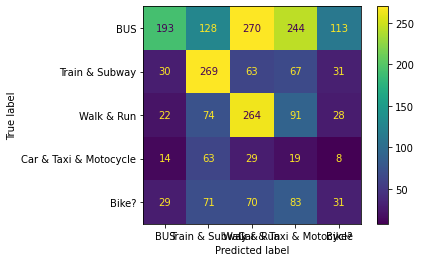

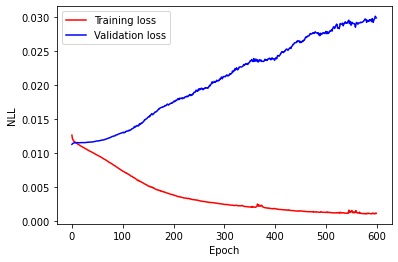

In [ ]:
batch_size = 128
num_epochs = 600
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        
        # compute gradients given loss
        y_batch = Variable(torch.from_numpy(y_train[slc]).long()).reshape(-1)
        # print(output.shape, y_batch.shape)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()

        # for item in net.named_parameters():
        #     h = item[1].register_hook(lambda grad: print(grad))
        loss.backward()

        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm(net.parameters(), 0.25)
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_train):
            slc = get_slice(i, batch_size)
            # print(slc)
            x_batch = Variable(torch.from_numpy(x_train[slc]))
            
            output = net(x_batch.float().cuda()) # [seq, batch, num_direction*hidden_size]
            # print(output.shape)
            preds = torch.max(output, 1)[1]
            # print(preds.shape)
            # print('preds:', preds)
            
            train_targs += list(y_train[slc].reshape(-1))
            train_preds += list(preds.cpu().data.numpy())

    
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_valid):
            slc = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slc]))
            # print(x_batch)
            output = net(x_batch.float().cuda())
            # print(output)
            preds = torch.max(output, 1)[1]
            # print('preds:', preds)
            
            val_preds += list(preds.cpu().data.numpy())
            val_targs += list(y_valid[slc].reshape(-1))
            # Compute loss
            loss = criterion(output, y_batch.cuda())
            # Update loss
            epoch_validation_loss += loss.detach().cpu().numpy()

    train_acc_cur = accuracy_score(train_targs, train_preds)

    # print(val_targs)
    # print(val_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


[0.3377604166666667, 0.4278645833333333, 0.46484375, 0.47552083333333334, 0.48541666666666666, 0.4859375, 0.49166666666666664, 0.49375, 0.4981770833333333, 0.5, 0.5015625, 0.50234375, 0.50390625, 0.5046875, 0.5072916666666667, 0.50859375, 0.5106770833333333, 0.5130208333333334, 0.5143229166666666, 0.5158854166666667, 0.52109375, 0.5244791666666667, 0.5296875, 0.5330729166666667, 0.53671875, 0.5388020833333333, 0.54140625, 0.5455729166666666, 0.5473958333333333, 0.5505208333333333, 0.5544270833333333, 0.5546875, 0.5588541666666667, 0.5619791666666667, 0.5674479166666667, 0.5731770833333333, 0.5765625, 0.58125, 0.5869791666666667, 0.59140625, 0.5955729166666667, 0.6002604166666666, 0.60078125, 0.6052083333333333, 0.6106770833333334, 0.6119791666666666, 0.6143229166666667, 0.6174479166666667, 0.6153645833333333, 0.62109375, 0.6265625, 0.62890625, 0.6328125, 0.6330729166666667, 0.6380208333333334, 0.63828125, 0.6432291666666666, 0.6453125, 0.6466145833333333, 0.6421875, 0.6479166666666667,

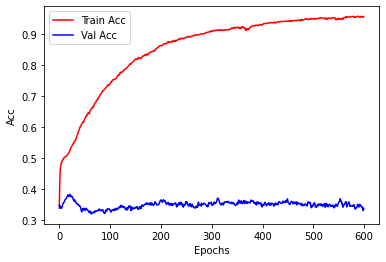


Test set Acc:  0.329876


In [ ]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test.reshape(-1)), list(preds.cpu().data.numpy()))))

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.model_selection import train_test_split
from geopy.distance import vincenty, geodesic

Check what GPU is used.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jan  4 13:10:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    34W / 250W |  15843MiB / 16280MiB |      1%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Define a Recurrent Neural Network seq_8

> Indented block



In [103]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

Build the network based on the <span class="mark">yellow colored parameters</span>

![image.png](attachment:image.png)

In [104]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


Running GPU.


### define train, validation, test set

In [105]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# split to train, valid, test set

x_remain_ind, x_test_ind, y_remain_ind, y_test_ind = train_test_split(list(range(len(userRNN8))),list(range(len(labelRNN8))),test_size=0.2, random_state = 1)
x_train_ind, x_valid_ind, y_train_ind, y_valid_ind = train_test_split(x_remain_ind,y_remain_ind,test_size =0.375, random_state = 1)



print(x_train_ind)
print(x_valid_ind)
print(x_test_ind)
print(y_train_ind)
print(y_valid_ind)
print(y_test_ind)

print(f'We have {len(x_train_ind)} users in the training set')
print(f'We have {len(x_valid_ind)} users in the validation set.')

def flatten_user_channel(x):
    return [[[c for p in sege for c in p] for sege in trip] for user in x for trip in user]
def flatten_user(x):
    return [trip for user in x for trip in user]

print(f'We have {len(x_test_ind)} users in the test set.')
x_train =np.array(flatten_user_channel([userRNN8[i] for i in x_train_ind]))
x_valid = np.array(flatten_user_channel([userRNN8[i] for i in x_valid_ind]))
x_test = np.array(flatten_user_channel([userRNN8[i] for i in x_test_ind]))

y_train = np.array(flatten_user([labelRNN8[i] for i in y_train_ind]))
y_valid = np.array(flatten_user([labelRNN8[i] for i in y_valid_ind]))
y_test = np.array(flatten_user([labelRNN8[i] for i in y_test_ind]))

print("Total segments of x_train",sum([np.array(i).shape[0] for i in x_train]), "*",  np.array(x_train[0]).shape)
print("Total segments of y_train",sum([np.array(i).shape[0] for i in y_train]), "*", np.array(y_train[0]).shape)

print("Total segments of x_valid",sum([np.array(i).shape[0] for i in x_valid]), "*",  np.array(x_valid[0]).shape)
print("Total segments of y_valid",sum([np.array(i).shape[0] for i in y_valid]),"*", np.array(y_valid[0]).shape)

print("Total segments of x_test",sum([np.array(i).shape[0] for i in x_test]), "*",  np.array(x_test[0]).shape)
print("Total segments of y_test",sum([np.array(i).shape[0] for i in y_test]), "*", np.array(y_test[0]).shape)

[9, 6, 18, 10, 15, 22, 5, 11, 7, 13, 16, 1, 23]
[12, 26, 4, 0, 8, 27, 25, 2, 21]
[24, 17, 19, 20, 14, 3]
[9, 6, 18, 10, 15, 22, 5, 11, 7, 13, 16, 1, 23]
[12, 26, 4, 0, 8, 27, 25, 2, 21]
[24, 17, 19, 20, 14, 3]
We have 13 users in the training set
We have 9 users in the validation set.
We have 6 users in the test set.
Total segments of x_train 2800 * (8, 800)
Total segments of y_train 2800 * (8,)
Total segments of x_valid 3088 * (8, 800)
Total segments of y_valid 3088 * (8,)
Total segments of x_test 416 * (8, 800)
Total segments of y_test 416 * (8,)


batch_size = 10
[12, 1, 0, 14, 6, 3, 20, 17, 16, 10, 11, 13, 21]
[5, 4, 2, 22, 15]
[18, 7, 8, 9, 19]

batch_size = 20
[9, 18, 13, 20, 1, 22, 12, 10, 17, 0, 4, 16, 21]
[11, 19, 8, 2, 5]
[15, 14, 3, 6, 7]

1. Batch size / shuffle
2. LSTM / GRU
3. Confusion Matrix



In [106]:
np.array(x_train).shape

(350, 8, 800)

### Define Network

In [107]:
# Hyper-parameters
input_size = 800
hidden_size = 5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size = hidden_size, num_layers = 2, bidirectional = True, bias = False, batch_first = True ) 
        #discuss bidirectional and compare with Gru and LSTM
        self.dropout = nn.Dropout2d(p = 0.7)
        self.layernorm = nn.LayerNorm([2* hidden_size])
        self.l_out1 = nn.Linear(in_features=2*hidden_size,
                            out_features= 5,
                            bias=False)

    def forward(self, x):

        # RNN returns output and last hidden state
        # print("1    ", x.shape)
        x, h = self.rnn(x)

        x = self.layernorm(x)
        # print("2    ", x.shape)
        # Flatten output for feed-forward layer
        x = relu(x.view(-1, 2 * self.rnn.hidden_size))
        # print("3    ", x.shape)
        # x = self.dropout(x)
        # Output layer
        # x = self.l_out1(x)
        x = relu(self.l_out1(x))
        # print("4    ", x.shape)

        
        return x

In [108]:
# Initialize a new network
net = Net()
if use_cuda:
    net.cuda()
print(net)

# Define a loss function and optimizer for this problem
y_train_mode_spread = [sege for trip in y_train for sege in trip]
print(y_train_mode_spread)
unique, counts = np.unique(y_train_mode_spread, return_counts=True)
print(unique, counts)
weights = torch.FloatTensor(1/counts * np.min(counts)).cuda()
print(weights)
criterion = nn.CrossEntropyLoss(weight= weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr =0.001, betas=(0.9, 0.999),eps = 1e-08, weight_decay=0.0001 ) # early stop/ auto decay
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001 ) # early stop/ auto decay

#ADAM lr=0.001, wc=0.0001


Net(
  (rnn): LSTM(800, 5, num_layers=2, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout2d(p=0.7, inplace=False)
  (layernorm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (l_out1): Linear(in_features=10, out_features=5, bias=False)
)
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [109]:
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

32870

In [110]:
np.array(x_train[4]).shape

(8, 800)

### define criterion

In [111]:
print(x_valid)

[[[1.87423161e-02 3.74846321e-03 7.49692642e-04 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.64183353e-03
   5.28366706e-04 2.44447867e+01]
  [6.69010855e-02 2.23003618e-02 7.43345395e-03 ... 1.61357045e-02
   8.06785227e-03 3.01248839e+02]
  ...
  [6.77634737e-02 3.38817369e-02 1.69408684e-02 ... 5.85424960e-02
   2.92712480e-02 4.57910200e+00]
  [2.62475773e-01 1.31237887e-01 6.56189433e-02 ... 2.00013078e-02
   1.00006539e-02 1.71293546e+01]
  [4.53394831e-02 2.26697416e-02 1.13348708e-02 ... 2.43394270e-02
   1.21697135e-02 1.32061158e+01]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.18218704e-01
   5.91093522e-02 2.52346439e+00]
  [2.26919434e-01 1.13459717e-01 5.67298585e-02 ... 1.26303958e-01
   6.31519788e-02 1.52702288e+01]
  [2.44525217e-01 1.22262608e-01 6.11313042e-02 ... 6.88113799e-02
   1.37622760e-02 2.16665485e+00]
  ...
  [3.17353689e-01 1.58676844e-01 7.93384222e-02 ... 1.17210779e-01
   5.86053

### Train the network

Epoch  1 : Train Loss 0.023529 , Validation Loss 0.026165, Train acc 0.126562, Valid acc 0.111654


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 11 : Train Loss 0.022295 , Validation Loss 0.025897, Train acc 0.250000, Valid acc 0.376302
Epoch 21 : Train Loss 0.021522 , Validation Loss 0.026099, Train acc 0.324219, Valid acc 0.570638
Epoch 31 : Train Loss 0.020854 , Validation Loss 0.026236, Train acc 0.381250, Valid acc 0.592773
Epoch 41 : Train Loss 0.020192 , Validation Loss 0.026596, Train acc 0.416797, Valid acc 0.600911
Epoch 51 : Train Loss 0.019498 , Validation Loss 0.026926, Train acc 0.453906, Valid acc 0.599284
Epoch 61 : Train Loss 0.018719 , Validation Loss 0.027270, Train acc 0.482031, Valid acc 0.595378
Epoch 71 : Train Loss 0.017971 , Validation Loss 0.027670, Train acc 0.505469, Valid acc 0.600260
Epoch 81 : Train Loss 0.017233 , Validation Loss 0.028113, Train acc 0.534766, Valid acc 0.589844
Epoch 91 : Train Loss 0.016329 , Validation Loss 0.028868, Train acc 0.563281, Valid acc 0.581706
Epoch 101 : Train Loss 0.015502 , Validation Loss 0.029587, Train acc 0.578516, Valid acc 0.578451
Epoch 111 : Train L

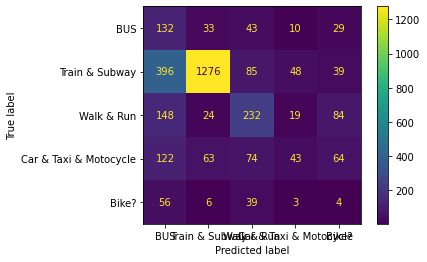

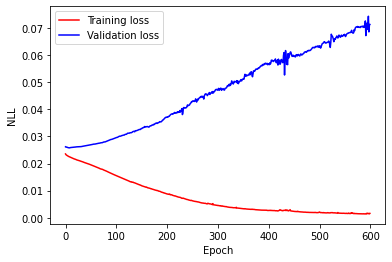

In [112]:
batch_size = 64
num_epochs = 600
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        
        # compute gradients given loss
        y_batch = Variable(torch.from_numpy(y_train[slc]).long()).reshape(-1)
        # print(output.shape, y_batch.shape)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()

        # for item in net.named_parameters():
        #     h = item[1].register_hook(lambda grad: print(grad))
        loss.backward()

        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm(net.parameters(), 0.25)
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_train):
            slc = get_slice(i, batch_size)
            # print(slc)
            x_batch = Variable(torch.from_numpy(x_train[slc]))
            
            output = net(x_batch.float().cuda()) # [seq, batch, num_direction*hidden_size]
            # print(output.shape)
            preds = torch.max(output, 1)[1]
            # print(preds.shape)
            # print('preds:', preds)
            
            train_targs += list(y_train[slc].reshape(-1))
            train_preds += list(preds.cpu().data.numpy())

    
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_valid):
            slc = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slc]))
            # print(x_batch)
            output = net(x_batch.float().cuda())
            # print(output)
            preds = torch.max(output, 1)[1]
            # print('preds:', preds)
            
            val_preds += list(preds.cpu().data.numpy())
            val_targs += list(y_valid[slc].reshape(-1))
            # Compute loss
            loss = criterion(output, y_batch.cuda())
            # Update loss
            epoch_validation_loss += loss.detach().cpu().numpy()

    train_acc_cur = accuracy_score(train_targs, train_preds)

    # print(val_targs)
    # print(val_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


[0.1265625, 0.144921875, 0.150390625, 0.160546875, 0.174609375, 0.1890625, 0.199609375, 0.211328125, 0.224609375, 0.2421875, 0.25, 0.25859375, 0.2703125, 0.280859375, 0.291796875, 0.296875, 0.30625, 0.312109375, 0.316015625, 0.317578125, 0.32421875, 0.33359375, 0.3328125, 0.33671875, 0.344140625, 0.353125, 0.3546875, 0.363671875, 0.372265625, 0.378125, 0.38125, 0.390234375, 0.394921875, 0.397265625, 0.400390625, 0.403515625, 0.4078125, 0.409375, 0.412109375, 0.417578125, 0.416796875, 0.41796875, 0.420703125, 0.428125, 0.430078125, 0.434765625, 0.43671875, 0.441796875, 0.444921875, 0.451171875, 0.45390625, 0.455078125, 0.46015625, 0.462890625, 0.466015625, 0.469140625, 0.471484375, 0.476171875, 0.48046875, 0.48125, 0.48203125, 0.48203125, 0.481640625, 0.484765625, 0.48828125, 0.48828125, 0.49375, 0.499609375, 0.50859375, 0.503515625, 0.50546875, 0.5125, 0.5109375, 0.5125, 0.522265625, 0.5203125, 0.525390625, 0.528515625, 0.52734375, 0.533203125, 0.534765625, 0.537109375, 0.5375, 0.54257

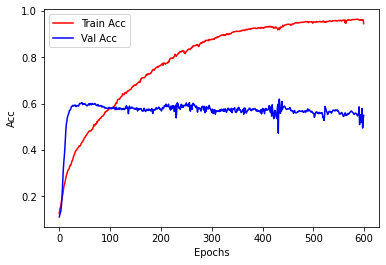


Test set Acc:  0.310096


In [113]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test.reshape(-1)), list(preds.cpu().data.numpy()))))

## Define a Recurrent Neural Network seq_8 + BiGRU

> Indented block



In [114]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

Build the network based on the <span class="mark">yellow colored parameters</span>

![image.png](attachment:image.png)

In [115]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


Running GPU.


### define train, validation, test set

batch_size = 10
[12, 1, 0, 14, 6, 3, 20, 17, 16, 10, 11, 13, 21]
[5, 4, 2, 22, 15]
[18, 7, 8, 9, 19]

batch_size = 20
[9, 18, 13, 20, 1, 22, 12, 10, 17, 0, 4, 16, 21]
[11, 19, 8, 2, 5]
[15, 14, 3, 6, 7]

1. Batch size / shuffle
2. LSTM / GRU
3. Confusion Matrix



In [116]:
np.array(x_train).shape

(350, 8, 800)

### Define Network

In [117]:
# Hyper-parameters
input_size = 800
hidden_size = 5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size = hidden_size, num_layers = 2, bidirectional = True, bias = False, batch_first = True ) 
        #discuss bidirectional and compare with Gru and LSTM
        self.dropout = nn.Dropout2d(p = 0.7)
        self.layernorm = nn.LayerNorm([2* hidden_size])
        self.l_out1 = nn.Linear(in_features=2*hidden_size,
                            out_features= 5,
                            bias=False)

    def forward(self, x):

        # RNN returns output and last hidden state
        # print("1    ", x.shape)
        x, h = self.rnn(x)

        x = self.layernorm(x)
        # print("2    ", x.shape)
        # Flatten output for feed-forward layer
        x = relu(x.view(-1, 2 * self.rnn.hidden_size))
        # print("3    ", x.shape)
        # x = self.dropout(x)
        # Output layer
        # x = self.l_out1(x)
        x = relu(self.l_out1(x))
        # print("4    ", x.shape)

        
        return x

In [118]:
# Initialize a new network
net = Net()
if use_cuda:
    net.cuda()
print(net)

# Define a loss function and optimizer for this problem
y_train_mode_spread = [sege for trip in y_train for sege in trip]
print(y_train_mode_spread)
unique, counts = np.unique(y_train_mode_spread, return_counts=True)
print(unique, counts)
weights = torch.FloatTensor(1/counts * np.min(counts)).cuda()
print(weights)
criterion = nn.CrossEntropyLoss(weight= weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr =0.001, betas=(0.9, 0.999),eps = 1e-08, weight_decay=0.0001 ) # early stop/ auto decay
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001 ) # early stop/ auto decay

#ADAM lr=0.001, wc=0.0001


Net(
  (rnn): LSTM(800, 5, num_layers=2, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout2d(p=0.7, inplace=False)
  (layernorm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (l_out1): Linear(in_features=10, out_features=5, bias=False)
)
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [119]:
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

32870

In [120]:
np.array(x_train[4]).shape

(8, 800)

### Train the network

Epoch  1 : Train Loss 0.023394 , Validation Loss 0.027138, Train acc 0.107422, Valid acc 0.117839


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 11 : Train Loss 0.022292 , Validation Loss 0.026431, Train acc 0.264844, Valid acc 0.455729
Epoch 21 : Train Loss 0.021694 , Validation Loss 0.026366, Train acc 0.401172, Valid acc 0.511719
Epoch 31 : Train Loss 0.021129 , Validation Loss 0.026561, Train acc 0.445312, Valid acc 0.536133
Epoch 41 : Train Loss 0.020512 , Validation Loss 0.026844, Train acc 0.462109, Valid acc 0.537435
Epoch 51 : Train Loss 0.019818 , Validation Loss 0.027245, Train acc 0.498047, Valid acc 0.549479
Epoch 61 : Train Loss 0.019123 , Validation Loss 0.027570, Train acc 0.520703, Valid acc 0.563477
Epoch 71 : Train Loss 0.018437 , Validation Loss 0.028204, Train acc 0.546484, Valid acc 0.577799
Epoch 81 : Train Loss 0.017682 , Validation Loss 0.028921, Train acc 0.558594, Valid acc 0.578451
Epoch 91 : Train Loss 0.016968 , Validation Loss 0.029523, Train acc 0.578906, Valid acc 0.578776
Epoch 101 : Train Loss 0.016252 , Validation Loss 0.030357, Train acc 0.600000, Valid acc 0.586914
Epoch 111 : Train L

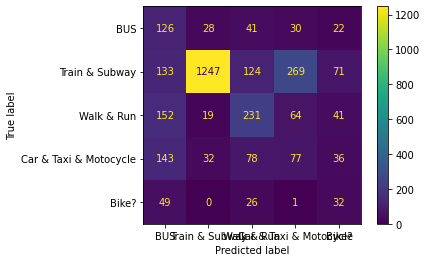

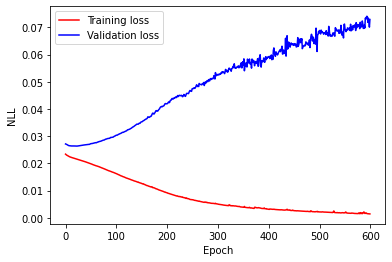

In [121]:
batch_size = 64
num_epochs = 600
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        
        # compute gradients given loss
        y_batch = Variable(torch.from_numpy(y_train[slc]).long()).reshape(-1)
        # print(output.shape, y_batch.shape)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()

        # for item in net.named_parameters():
        #     h = item[1].register_hook(lambda grad: print(grad))
        loss.backward()

        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm(net.parameters(), 0.25)
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_train):
            slc = get_slice(i, batch_size)
            # print(slc)
            x_batch = Variable(torch.from_numpy(x_train[slc]))
            
            output = net(x_batch.float().cuda()) # [seq, batch, num_direction*hidden_size]
            # print(output.shape)
            preds = torch.max(output, 1)[1]
            # print(preds.shape)
            # print('preds:', preds)
            
            train_targs += list(y_train[slc].reshape(-1))
            train_preds += list(preds.cpu().data.numpy())

    
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_valid):
            slc = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slc]))
            # print(x_batch)
            output = net(x_batch.float().cuda())
            # print(output)
            preds = torch.max(output, 1)[1]
            # print('preds:', preds)
            
            val_preds += list(preds.cpu().data.numpy())
            val_targs += list(y_valid[slc].reshape(-1))
            # Compute loss
            loss = criterion(output, y_batch.cuda())
            # Update loss
            epoch_validation_loss += loss.detach().cpu().numpy()

    train_acc_cur = accuracy_score(train_targs, train_preds)

    # print(val_targs)
    # print(val_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


[0.107421875, 0.12109375, 0.1296875, 0.13828125, 0.15625, 0.17421875, 0.197265625, 0.21328125, 0.23515625, 0.24921875, 0.26484375, 0.287109375, 0.307421875, 0.32421875, 0.341796875, 0.356640625, 0.367578125, 0.373046875, 0.3828125, 0.39140625, 0.401171875, 0.407421875, 0.416015625, 0.423046875, 0.42734375, 0.43203125, 0.438671875, 0.440625, 0.44296875, 0.4453125, 0.4453125, 0.446484375, 0.446875, 0.45390625, 0.454296875, 0.452734375, 0.4546875, 0.455078125, 0.458984375, 0.460546875, 0.462109375, 0.465234375, 0.47265625, 0.47421875, 0.4765625, 0.47890625, 0.484375, 0.484765625, 0.496484375, 0.496875, 0.498046875, 0.496484375, 0.500390625, 0.503125, 0.50859375, 0.51328125, 0.51640625, 0.51796875, 0.51875, 0.514453125, 0.520703125, 0.524609375, 0.526953125, 0.530078125, 0.536328125, 0.538671875, 0.537109375, 0.53828125, 0.540234375, 0.5421875, 0.546484375, 0.546484375, 0.547265625, 0.548046875, 0.546875, 0.548046875, 0.551171875, 0.55625, 0.55546875, 0.559375, 0.55859375, 0.56171875, 0.56

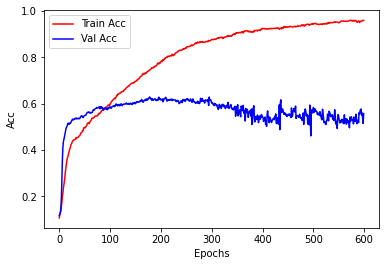


Test set Acc:  0.382212


In [122]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test.reshape(-1)), list(preds.cpu().data.numpy()))))

## Define a Recurrent Neural Network seq_10

In [ ]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

Build the network based on the <span class="mark">yellow colored parameters</span>

![image.png](attachment:image.png)

In [ ]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


Running GPU.


### define train, validation, test set

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# split to train, valid, test set

print(x_train_ind)
print(x_valid_ind)
print(x_test_ind)
print(y_train_ind)
print(y_valid_ind)
print(y_test_ind)

print(f'We have {len(x_train_ind)} users in the training set')
print(f'We have {len(x_valid_ind)} users in the validation set.')

def flatten_user_channel(x):
    return [[[c for p in sege for c in p] for sege in trip] for user in x for trip in user]
def flatten_user(x):
    return [trip for user in x for trip in user]

print(f'We have {len(x_test_ind)} users in the test set.')
x_train =np.array(flatten_user_channel([userRNN10[i] for i in x_train_ind]))
x_valid = np.array(flatten_user_channel([userRNN10[i] for i in x_valid_ind]))
x_test = np.array(flatten_user_channel([userRNN10[i] for i in x_test_ind]))

y_train = np.array(flatten_user([labelRNN10[i] for i in y_train_ind]))
y_valid = np.array(flatten_user([labelRNN10[i] for i in y_valid_ind]))
y_test = np.array(flatten_user([labelRNN10[i] for i in y_test_ind]))

print("Total segments of x_train",sum([np.array(i).shape[0] for i in x_train]), "*",  np.array(x_train[0]).shape)
print("Total segments of y_train",sum([np.array(i).shape[0] for i in y_train]), "*", np.array(y_train[0]).shape)

print("Total segments of x_valid",sum([np.array(i).shape[0] for i in x_valid]), "*",  np.array(x_valid[0]).shape)
print("Total segments of y_valid",sum([np.array(i).shape[0] for i in y_valid]),"*", np.array(y_valid[0]).shape)

print("Total segments of x_test",sum([np.array(i).shape[0] for i in x_test]), "*",  np.array(x_test[0]).shape)
print("Total segments of y_test",sum([np.array(i).shape[0] for i in y_test]), "*", np.array(y_test[0]).shape)

[9, 17, 7, 24, 12, 18, 6, 22, 26, 5, 15, 19, 10, 11, 1, 25]
[13, 0, 3, 14, 23, 4]
[2, 21, 20, 8, 27, 16]
[9, 17, 7, 24, 12, 18, 6, 22, 26, 5, 15, 19, 10, 11, 1, 25]
[13, 0, 3, 14, 23, 4]
[2, 21, 20, 8, 27, 16]
We have 16 users in the training set
We have 6 users in the validation set.
We have 6 users in the test set.
Total segments of x_train 2380 * (10, 800)
Total segments of y_train 2380 * (10,)
Total segments of x_valid 2080 * (10, 800)
Total segments of y_valid 2080 * (10,)
Total segments of x_test 730 * (10, 800)
Total segments of y_test 730 * (10,)


batch_size = 10
[12, 1, 0, 14, 6, 3, 20, 17, 16, 10, 11, 13, 21]
[5, 4, 2, 22, 15]
[18, 7, 8, 9, 19]

batch_size = 20
[9, 18, 13, 20, 1, 22, 12, 10, 17, 0, 4, 16, 21]
[11, 19, 8, 2, 5]
[15, 14, 3, 6, 7]

1. Batch size / shuffle
2. LSTM / GRU
3. Confusion Matrix



In [ ]:
np.array(x_train).shape

(238, 10, 800)

### Define Network

In [ ]:
# Hyper-parameters
input_size = 800
hidden_size = 5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size = hidden_size, num_layers = 3, bidirectional = True, bias = False, batch_first = True ) 
        #discuss bidirectional and compare with Gru and LSTM
        self.dropout = nn.Dropout2d(p = 0.7)
        self.layernorm = nn.LayerNorm([2* hidden_size])
        self.l_out1 = nn.Linear(in_features=2*hidden_size,
                            out_features= 5,
                            bias=False)

    def forward(self, x):

        # RNN returns output and last hidden state
        # print("1    ", x.shape)
        x, h = self.rnn(x)

        x = self.layernorm(x)
        # print("2    ", x.shape)
        # Flatten output for feed-forward layer
        x = relu(x.view(-1, 2 * self.rnn.hidden_size))
        # print("3    ", x.shape)
        # x = self.dropout(x)
        # Output layer
        # x = self.l_out1(x)
        x = relu(self.l_out1(x))
        # print("4    ", x.shape)

        
        return x

In [ ]:
# Initialize a new network
net = Net()
if use_cuda:
    net.cuda()
print(net)

# Define a loss function and optimizer for this problem
y_train_mode_spread = [sege for trip in y_train for sege in trip]
print(y_train_mode_spread)
unique, counts = np.unique(y_train_mode_spread, return_counts=True)
print(unique, counts)
weights = torch.FloatTensor(1/counts * np.min(counts)).cuda()
print(weights)
criterion = nn.CrossEntropyLoss(weight= weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr =0.001, betas=(0.9, 0.999),eps = 1e-08, weight_decay=0.0001 ) # early stop/ auto decay
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001 ) # early stop/ auto decay

#ADAM lr=0.001, wc=0.0001


Net(
  (rnn): LSTM(800, 5, num_layers=3, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout2d(p=0.7, inplace=False)
  (layernorm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (l_out1): Linear(in_features=10, out_features=5, bias=False)
)
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 

In [ ]:
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

33470

In [ ]:
np.array(x_train[4]).shape

(10, 800)

### define criterion

In [ ]:
print(x_valid)

[[[4.56397105e-04 1.52132368e-05 5.07107894e-07 ... 0.00000000e+00
   0.00000000e+00 2.97601335e+01]
  [8.08622524e-03 4.04311262e-03 2.02155631e-03 ... 1.90279727e-02
   9.51398636e-03 1.98985873e+01]
  [3.89129190e-02 1.29709730e-02 4.32365767e-03 ... 4.69659447e-02
   2.34829723e-02 4.22659131e+00]
  ...
  [1.01063325e-01 3.36877750e-02 1.12292583e-02 ... 5.43867648e-02
   2.71933824e-02 1.48296297e+00]
  [1.24711399e-01 6.23556995e-02 3.11778498e-02 ... 5.85749006e-02
   2.92874503e-02 6.13047698e-01]
  [5.87058593e-02 2.93529296e-02 1.46764648e-02 ... 7.53905297e-02
   3.76952648e-02 6.48313337e+00]]

 [[3.18254159e-02 1.06084720e-02 3.53615732e-03 ... 1.10712969e-01
   5.53564843e-02 2.29713516e+00]
  [2.21391857e-01 1.10695929e-01 5.53479643e-02 ... 8.50818553e-02
   4.25409277e-02 1.35191918e-02]
  [1.83103156e-01 9.15515780e-02 4.57757890e-02 ... 3.97270948e-02
   9.93177370e-03 2.47898618e+00]
  ...
  [1.43233885e-01 7.16169424e-02 3.58084712e-02 ... 1.45643674e-01
   7.28218

### Train the network

Epoch  1 : Train Loss 0.006665 , Validation Loss 0.007666, Train acc 0.194531, Valid acc 0.156250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 11 : Train Loss 0.006424 , Validation Loss 0.007717, Train acc 0.239844, Valid acc 0.260937
Epoch 21 : Train Loss 0.006264 , Validation Loss 0.007813, Train acc 0.275781, Valid acc 0.357031
Epoch 31 : Train Loss 0.006100 , Validation Loss 0.007871, Train acc 0.300000, Valid acc 0.392188
Epoch 41 : Train Loss 0.005934 , Validation Loss 0.007930, Train acc 0.331250, Valid acc 0.444531
Epoch 51 : Train Loss 0.005744 , Validation Loss 0.008020, Train acc 0.365625, Valid acc 0.485156
Epoch 61 : Train Loss 0.005559 , Validation Loss 0.008081, Train acc 0.401562, Valid acc 0.514062
Epoch 71 : Train Loss 0.005367 , Validation Loss 0.008162, Train acc 0.427344, Valid acc 0.524219
Epoch 81 : Train Loss 0.005171 , Validation Loss 0.008278, Train acc 0.445312, Valid acc 0.527344
Epoch 91 : Train Loss 0.004965 , Validation Loss 0.008407, Train acc 0.479687, Valid acc 0.534375
Epoch 101 : Train Loss 0.004743 , Validation Loss 0.008510, Train acc 0.525781, Valid acc 0.548438
Epoch 111 : Train L

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


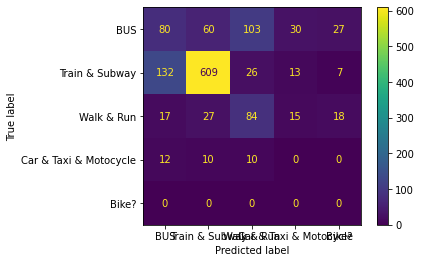

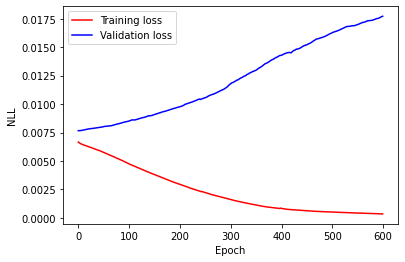

In [ ]:
batch_size = 128
num_epochs = 600
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        
        # compute gradients given loss
        y_batch = Variable(torch.from_numpy(y_train[slc]).long()).reshape(-1)
        # print(output.shape, y_batch.shape)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()

        # for item in net.named_parameters():
        #     h = item[1].register_hook(lambda grad: print(grad))
        loss.backward()

        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm(net.parameters(), 0.25)
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_train):
            slc = get_slice(i, batch_size)
            # print(slc)
            x_batch = Variable(torch.from_numpy(x_train[slc]))
            
            output = net(x_batch.float().cuda()) # [seq, batch, num_direction*hidden_size]
            # print(output.shape)
            preds = torch.max(output, 1)[1]
            # print(preds.shape)
            # print('preds:', preds)
            
            train_targs += list(y_train[slc].reshape(-1))
            train_preds += list(preds.cpu().data.numpy())

    
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_valid):
            slc = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slc]))
            # print(x_batch)
            output = net(x_batch.float().cuda())
            # print(output)
            preds = torch.max(output, 1)[1]
            # print('preds:', preds)
            
            val_preds += list(preds.cpu().data.numpy())
            val_targs += list(y_valid[slc].reshape(-1))
            # Compute loss
            loss = criterion(output, y_batch.cuda())
            # Update loss
            epoch_validation_loss += loss.detach().cpu().numpy()

    train_acc_cur = accuracy_score(train_targs, train_preds)

    # print(val_targs)
    # print(val_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


[0.19453125, 0.2078125, 0.2125, 0.2125, 0.2171875, 0.21875, 0.225, 0.2328125, 0.2375, 0.23984375, 0.23984375, 0.24375, 0.24921875, 0.25390625, 0.26015625, 0.26171875, 0.26640625, 0.26953125, 0.2703125, 0.27421875, 0.27578125, 0.27578125, 0.28046875, 0.28515625, 0.28515625, 0.2890625, 0.290625, 0.29375, 0.29453125, 0.29609375, 0.3, 0.3015625, 0.30546875, 0.309375, 0.3109375, 0.31484375, 0.3203125, 0.32421875, 0.325, 0.32734375, 0.33125, 0.33203125, 0.3375, 0.3390625, 0.34765625, 0.3546875, 0.35703125, 0.36015625, 0.3625, 0.3640625, 0.365625, 0.3671875, 0.36875, 0.37109375, 0.371875, 0.375, 0.37890625, 0.3828125, 0.38828125, 0.39609375, 0.4015625, 0.403125, 0.403125, 0.4109375, 0.4140625, 0.4171875, 0.41875, 0.42109375, 0.42421875, 0.4265625, 0.42734375, 0.43203125, 0.4359375, 0.434375, 0.4359375, 0.43828125, 0.43828125, 0.44140625, 0.44296875, 0.4421875, 0.4453125, 0.446875, 0.4484375, 0.45234375, 0.45703125, 0.4578125, 0.45859375, 0.46171875, 0.46796875, 0.47578125, 0.4796875, 0.483593

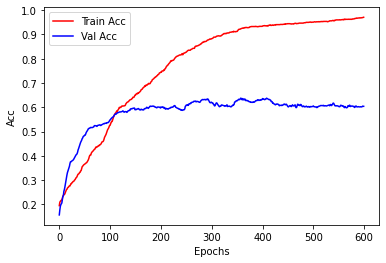


Test set Acc:  0.346575


In [ ]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test.reshape(-1)), list(preds.cpu().data.numpy()))))

## Define a Recurrent Neural Network seq_12

In [ ]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

Build the network based on the <span class="mark">yellow colored parameters</span>

![image.png](attachment:image.png)

In [ ]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


Running GPU.


### define train, validation, test set

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# split to train, valid, test set

print(x_train_ind)
print(x_valid_ind)
print(x_test_ind)
print(y_train_ind)
print(y_valid_ind)
print(y_test_ind)

print(f'We have {len(x_train_ind)} users in the training set')
print(f'We have {len(x_valid_ind)} users in the validation set.')

def flatten_user_channel(x):
    return [[[c for p in sege for c in p] for sege in trip] for user in x for trip in user]
def flatten_user(x):
    return [trip for user in x for trip in user]

print(f'We have {len(x_test_ind)} users in the test set.')
x_train =np.array(flatten_user_channel([userRNN12[i] for i in x_train_ind]))
x_valid = np.array(flatten_user_channel([userRNN12[i] for i in x_valid_ind]))
x_test = np.array(flatten_user_channel([userRNN12[i] for i in x_test_ind]))

y_train = np.array(flatten_user([labelRNN12[i] for i in y_train_ind]))
y_valid = np.array(flatten_user([labelRNN12[i] for i in y_valid_ind]))
y_test = np.array(flatten_user([labelRNN12[i] for i in y_test_ind]))

print("Total segments of x_train",sum([np.array(i).shape[0] for i in x_train]), "*",  np.array(x_train[0]).shape)
print("Total segments of y_train",sum([np.array(i).shape[0] for i in y_train]), "*", np.array(y_train[0]).shape)

print("Total segments of x_valid",sum([np.array(i).shape[0] for i in x_valid]), "*",  np.array(x_valid[0]).shape)
print("Total segments of y_valid",sum([np.array(i).shape[0] for i in y_valid]),"*", np.array(y_valid[0]).shape)

print("Total segments of x_test",sum([np.array(i).shape[0] for i in x_test]), "*",  np.array(x_test[0]).shape)
print("Total segments of y_test",sum([np.array(i).shape[0] for i in y_test]), "*", np.array(y_test[0]).shape)

[14, 19, 16, 1, 22, 13, 18, 20, 8, 11, 5, 10, 3, 7]
[12, 21, 4, 23, 0]
[15, 6, 2, 17, 9]
[14, 19, 16, 1, 22, 13, 18, 20, 8, 11, 5, 10, 3, 7]
[12, 21, 4, 23, 0]
[15, 6, 2, 17, 9]
We have 14 users in the training set
We have 5 users in the validation set.
We have 5 users in the test set.
Total segments of x_train 1716 * (12, 800)
Total segments of y_train 1716 * (12,)
Total segments of x_valid 1752 * (12, 800)
Total segments of y_valid 1752 * (12,)
Total segments of x_test 828 * (12, 800)
Total segments of y_test 828 * (12,)


batch_size = 10
[12, 1, 0, 14, 6, 3, 20, 17, 16, 10, 11, 13, 21]
[5, 4, 2, 22, 15]
[18, 7, 8, 9, 19]

batch_size = 20
[9, 18, 13, 20, 1, 22, 12, 10, 17, 0, 4, 16, 21]
[11, 19, 8, 2, 5]
[15, 14, 3, 6, 7]

1. Batch size / shuffle
2. LSTM / GRU
3. Confusion Matrix



In [ ]:
np.array(x_train).shape

(143, 12, 800)

### Define Network

In [ ]:
# Hyper-parameters
input_size = 800
hidden_size = 5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size = hidden_size, num_layers = 3, bidirectional = True, bias = False, batch_first = True ) 
        #discuss bidirectional and compare with Gru and LSTM
        self.dropout = nn.Dropout2d(p = 0.7)
        self.layernorm = nn.LayerNorm([2* hidden_size])
        self.l_out1 = nn.Linear(in_features=2*hidden_size,
                            out_features= 5,
                            bias=False)

    def forward(self, x):

        # RNN returns output and last hidden state
        # print("1    ", x.shape)
        x, h = self.rnn(x)

        x = self.layernorm(x)
        # print("2    ", x.shape)
        # Flatten output for feed-forward layer
        x = relu(x.view(-1, 2 * self.rnn.hidden_size))
        # print("3    ", x.shape)
        # x = self.dropout(x)
        # Output layer
        # x = self.l_out1(x)
        x = relu(self.l_out1(x))
        # print("4    ", x.shape)

        
        return x

In [ ]:
# Initialize a new network
net = Net()
if use_cuda:
    net.cuda()
print(net)

# Define a loss function and optimizer for this problem
y_train_mode_spread = [sege for trip in y_train for sege in trip]
print(y_train_mode_spread)
unique, counts = np.unique(y_train_mode_spread, return_counts=True)
print(unique, counts)
weights = torch.FloatTensor(1/counts * np.min(counts)).cuda()
print(weights)
criterion = nn.CrossEntropyLoss(weight= weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr =0.001, betas=(0.9, 0.999),eps = 1e-08, weight_decay=0.0001 ) # early stop/ auto decay
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001 ) # early stop/ auto decay

#ADAM lr=0.001, wc=0.0001


Net(
  (rnn): LSTM(800, 5, num_layers=3, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout2d(p=0.7, inplace=False)
  (layernorm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (l_out1): Linear(in_features=10, out_features=5, bias=False)
)
[2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 2.0, 2.0, 

In [ ]:
np.sum([np.product(x.detach().cpu().numpy().shape) for x in net.parameters()])

33470

In [ ]:
np.array(x_train[4]).shape

(12, 800)

### define criterion

In [ ]:
print(x_valid)

[[[5.22624791e-03 2.61312395e-03 1.30656198e-03 ... 5.64140277e-02
   2.82070139e-02 9.23557622e+00]
  [1.08098528e-01 5.40492641e-02 2.70246320e-02 ... 9.71374241e-04
   4.85687121e-04 3.56758733e-07]
  [2.91412270e-03 1.45706135e-03 7.28530675e-04 ... 6.31466980e-02
   3.15733490e-02 5.07989474e+00]
  ...
  [7.95484670e-01 3.97742335e-01 1.98871167e-01 ... 8.75274665e-02
   4.37637333e-02 1.82279050e+00]
  [1.49073404e-01 7.45367020e-02 3.72683510e-02 ... 4.01596573e-01
   2.00798286e-01 1.87684477e+00]
  [7.94754029e-01 3.97377014e-01 1.98688507e-01 ... 3.92349514e-01
   1.96174757e-01 6.10725208e-01]]

 [[5.09155074e-01 2.54577537e-01 1.27288768e-01 ... 3.66919467e-01
   1.83459733e-01 9.04346842e-01]
  [7.38294847e-01 3.69147424e-01 1.84573712e-01 ... 3.72264363e-01
   1.86132182e-01 6.90969548e-01]
  [7.40746755e-01 3.70373377e-01 1.85186689e-01 ... 3.24911186e-01
   1.62455593e-01 7.50837732e-02]
  ...
  [5.79323289e-01 2.89661645e-01 1.44830822e-01 ... 3.36024901e-01
   1.68012

### Train the network

Epoch  1 : Train Loss 0.011241 , Validation Loss 0.011183, Train acc 0.235677, Valid acc 0.048828


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 11 : Train Loss 0.010906 , Validation Loss 0.011138, Train acc 0.316406, Valid acc 0.069010
Epoch 21 : Train Loss 0.010703 , Validation Loss 0.011152, Train acc 0.378906, Valid acc 0.108073
Epoch 31 : Train Loss 0.010501 , Validation Loss 0.011241, Train acc 0.434896, Valid acc 0.203125
Epoch 41 : Train Loss 0.010252 , Validation Loss 0.011323, Train acc 0.507161, Valid acc 0.505208
Epoch 51 : Train Loss 0.009991 , Validation Loss 0.011364, Train acc 0.550130, Valid acc 0.626302
Epoch 61 : Train Loss 0.009730 , Validation Loss 0.011445, Train acc 0.574870, Valid acc 0.684896
Epoch 71 : Train Loss 0.009455 , Validation Loss 0.011489, Train acc 0.617839, Valid acc 0.736979
Epoch 81 : Train Loss 0.009189 , Validation Loss 0.011592, Train acc 0.642578, Valid acc 0.753906
Epoch 91 : Train Loss 0.008926 , Validation Loss 0.011745, Train acc 0.668620, Valid acc 0.761068
Epoch 101 : Train Loss 0.008668 , Validation Loss 0.011887, Train acc 0.690755, Valid acc 0.757812
Epoch 111 : Train L

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


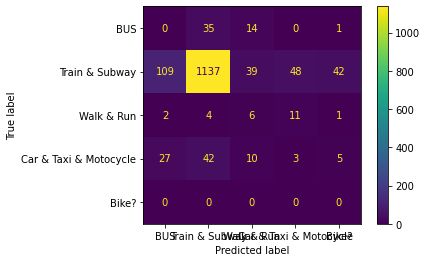

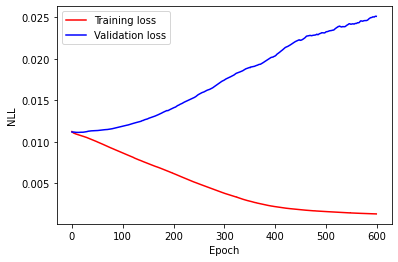

In [ ]:
batch_size = 128
num_epochs = 600
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
training_loss = []
validation_loss = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    net.train()
    for i in range(num_batches_train):
        slc = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slc]))
        # print(x_batch.shape)
        output = net(x_batch.float().cuda())
        
        # compute gradients given loss
        y_batch = Variable(torch.from_numpy(y_train[slc]).long()).reshape(-1)
        # print(output.shape, y_batch.shape)
        loss = criterion(output, y_batch.cuda())
        optimizer.zero_grad()

        # for item in net.named_parameters():
        #     h = item[1].register_hook(lambda grad: print(grad))
        loss.backward()

        # prevent gradient exploding
        torch.nn.utils.clip_grad_norm(net.parameters(), 0.25)
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().numpy()

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_train):
            slc = get_slice(i, batch_size)
            # print(slc)
            x_batch = Variable(torch.from_numpy(x_train[slc]))
            
            output = net(x_batch.float().cuda()) # [seq, batch, num_direction*hidden_size]
            # print(output.shape)
            preds = torch.max(output, 1)[1]
            # print(preds.shape)
            # print('preds:', preds)
            
            train_targs += list(y_train[slc].reshape(-1))
            train_preds += list(preds.cpu().data.numpy())

    
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad(): # 禁用梯度计算
        for i in range(num_batches_valid):
            slc = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(x_valid[slc]))
            # print(x_batch)
            output = net(x_batch.float().cuda())
            # print(output)
            preds = torch.max(output, 1)[1]
            # print('preds:', preds)
            
            val_preds += list(preds.cpu().data.numpy())
            val_targs += list(y_valid[slc].reshape(-1))
            # Compute loss
            loss = criterion(output, y_batch.cuda())
            # Update loss
            epoch_validation_loss += loss.detach().cpu().numpy()

    train_acc_cur = accuracy_score(train_targs, train_preds)

    # print(val_targs)
    # print(val_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(x_train))
    validation_loss.append(epoch_validation_loss/len(x_valid))
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Validation Loss %f, Train acc %f, Valid acc %f" % (
                epoch+1, training_loss[-1], validation_loss[-1], train_acc_cur, valid_acc_cur))
        
    if epoch == num_epochs-1:
        print(val_targs, val_preds)
        cm = confusion_matrix(val_targs, val_preds, labels = [0, 1, 2, 3, 4])
        ConfusionMatrixDisplay(cm, display_labels= ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']).plot(values_format = 'd')
        print(classification_report(val_targs, val_preds, target_names = ['BUS','Train & Subway', 'Walk & Run', 'Car & Taxi & Motocycle', 'Bike?']))


# Plot training and validation loss
import matplotlib.pyplot as plt
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


[0.23567708333333334, 0.24934895833333334, 0.2682291666666667, 0.271484375, 0.28515625, 0.2877604166666667, 0.294921875, 0.2994791666666667, 0.3046875, 0.3079427083333333, 0.31640625, 0.3196614583333333, 0.328125, 0.3372395833333333, 0.3463541666666667, 0.353515625, 0.357421875, 0.3619791666666667, 0.365234375, 0.369140625, 0.37890625, 0.3834635416666667, 0.38671875, 0.3932291666666667, 0.4036458333333333, 0.4088541666666667, 0.4114583333333333, 0.4186197916666667, 0.4244791666666667, 0.4303385416666667, 0.4348958333333333, 0.4407552083333333, 0.4459635416666667, 0.4544270833333333, 0.4576822916666667, 0.462890625, 0.4674479166666667, 0.4798177083333333, 0.4915364583333333, 0.5026041666666666, 0.5071614583333334, 0.5110677083333334, 0.515625, 0.5182291666666666, 0.521484375, 0.52734375, 0.5319010416666666, 0.5364583333333334, 0.5416666666666666, 0.544921875, 0.5501302083333334, 0.552734375, 0.5592447916666666, 0.5611979166666666, 0.5631510416666666, 0.564453125, 0.5611979166666666, 0.5

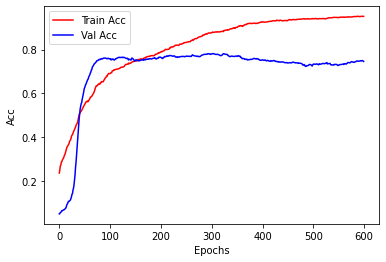


Test set Acc:  0.467391


In [ ]:
import matplotlib.pyplot as plt

epoch = np.arange(len(train_acc))
plt.figure()
print(train_acc)
print(valid_acc)
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch.float().cuda())
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(y_test.reshape(-1)), list(preds.cpu().data.numpy()))))